In [44]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [3]:
def shuffle_and_split_data(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data.iloc[train_indices], data.iloc[test_indices]

In [4]:
 def is_id_in_test_set(identifier, test_ratio):
     return crc32(np.int64(identifier)) < test_ratio * 2**32
 def split_data_with_id_hash(data, test_ratio, id_column):
     ids = data[id_column]
     in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
     return data.loc[~in_test_set], data.loc[in_test_set]

In [7]:
housing = load_housing_data()

In [8]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

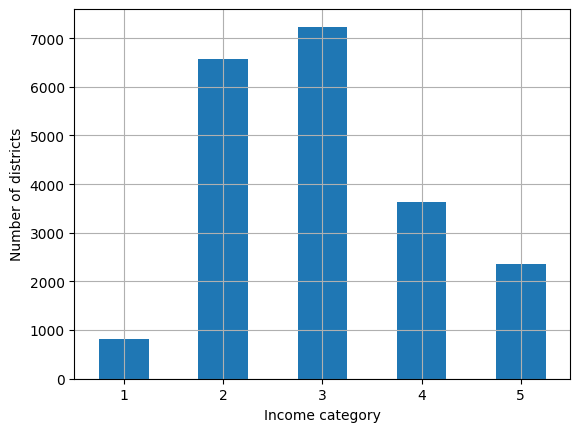

In [10]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [11]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
 strat_train_set_n = housing.iloc[train_index]
 strat_test_set_n = housing.iloc[test_index]
 strat_splits.append([strat_train_set_n, strat_test_set_n])

In [12]:
strat_train_set, strat_test_set = strat_splits[0]

In [13]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [14]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [15]:
strat_train_set["income_cat"].value_counts()/ len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [16]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("income_cat", axis=1, inplace=True)

In [23]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


## Explore and Visualize the Data to Gain Insights

In [22]:
traing_set_copy =  strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

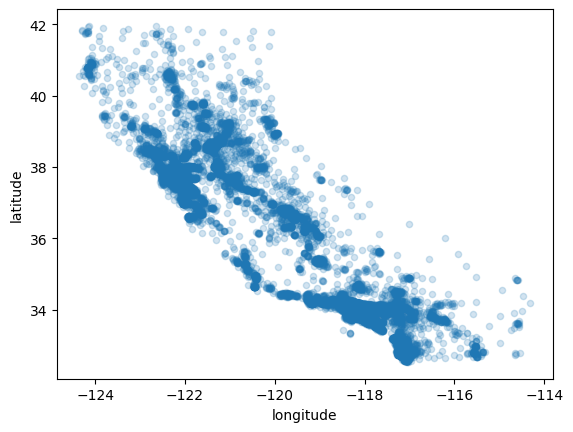

In [28]:
housing.plot(kind="scatter", x='longitude', y='latitude', alpha=0.2) #To see high density area

In [29]:
 housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
 housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
 housing["people_per_house"] = housing["population"] / housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

ValueError: could not convert string to float: 'NEAR BAY'

# Prepare the Data for Machine Learning Algorithms

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [34]:
imputer = SimpleImputer(strategy="median")

In [36]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [37]:
 X = imputer.transform(housing_num) # trained imputered to transform data.

In [38]:
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]], shape=(16512, 8))

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [45]:
housing_cat = housing[["ocean_proximity"]]  # since this is not numerical value, Converting it to numerical values
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)